# 확률론적 선형회귀모형

OLS(Ordinary Least Square) 방법을 사용하면 데이터에 대한 확률론적인 가정없이도 최적의 가중치를 계산할 수 있다. 그러나 이 경우에는 계산한 가중치가 어느 정도의 신뢰도 또는 안정성을 가지는지 확인할 수 있는 방법이 없다. 이를 확인하고자 하는 시도 중의 하나가 부트스트래핑(bootstrapping) 방법이다.

## 부트스트래핑

부트스트래핑(bootstrapping)은 회귀 분석에 사용한 데이터가 달라진다면 회귀 분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법이다. 

데이터가 확률 변수로부터 생성된 표본이거나 혹은 더 큰 모집단 중에서 선택한 표본이라고 가정한다면 회귀 분석의 결과는 분석에 사용한 표본에 의존적임을 알 수 있다. 만약 추가적인 다른 표본을 얻어서 다시 회귀 분석에 사용한다면 회귀 분석 결과 즉, 가중치 벡터의 값은 달라질 것이다.

그러나 현실적으로는 데이터를 추가적으로 얻기가 힘들기 때문에 부트스트래핑 방법에서는 기존의 데이터를 재표본화(re-sampling)하는 방법을 선택한다. 재표본화는 기존의 $D$개의 데이터에서 다시 $D$개의 데이터를 선택하되 중복 선택도 가능하게 한다. (resampling with replacement) 이 경우 이론적으로는 $O(2^D)$ 수준의 새로운 표본 집단을 얻을 수 있다.

In [13]:
from scipy.stats import norm

import numpy as np
import scipy as sp
from pandas.core import datetools
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()



C:\Users\User\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


직접 부트스트래핑을 실시해 보자. 우선 100개의 가상 데이터를 생성하여 이를 기반으로 회귀 분석을 실시한다.

In [19]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=0)

dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

print(result.params)
print(result.summary())

const    -1.628364
X1       42.853356
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sat, 14 Oct 2017   Prob (F-statistic):           2.21e-36
Time:                        09:24:00   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

다음으로 이 데이터에서 중복을 허락하여 N개의 데이터를 선택한 후 다시 회귀 분석을 한다. 이론적으로 약 $2^{100}$개의 경우가 있지만 1,000번만 반복해 본다.

In [15]:
%%time
N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

Wall time: 1.41 s


전체 가중치 집합을 히스토그램으로 나타내면 다음과 같다.

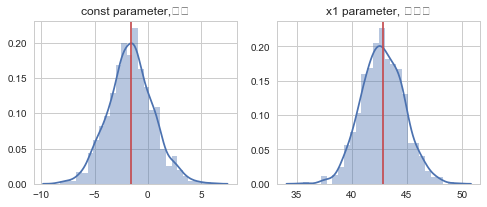

In [16]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter,절편")

ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter, 기울기")
plt.show()

평균과 분산은 다음과 같다.

In [4]:
params_c.mean(), params_c.std()

(-1.5641066502106973, 2.187396465686188)

In [5]:
params_x1.mean(), params_x1.std()

(42.896627122608393, 1.9173321100649763)

가중치 중 상수항의 경우 평균은 -1.6이지만 표분 편차가 2보다 크기 때문에 값이 0일 가능성을 배제할 수 없다.

이 결과를 StatsModels 의 회귀 분석 보고서와 비교하자.

In [6]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 26 Jun 2017   Prob (F-statistic):           2.21e-36
Time:                        19:03:07   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

보고서의 std err 항목을 보면 표준 편차의 경우 2.163 이고 마지막의 신뢰 구간(confidence interval)이 -5.920 ~ 2.663 임을 보이고 있다. 부트스트래핑으로 얻은 결과와 유사하다. 이 결과는 다음에 설명할 확률론적 가정에 의해 계산된 값이다.

## 확률론적 선형회귀모형

확률론적 선형회귀모형을 사용하면 부트스트래핑 없이도 회귀분석 결과의 통계적 특성을 구할 수 있다.

확률론적 선형회귀모형에서는 $y$가 확률 변수로부터 생성된 표본이라고 가정하며 다음과 같은 조건을 만족한다.

## 가정 1. 종속 변수의 분포에 대한 가정
1. 선형 정규분포 가정
 * 종속 변수 $y$는 기댓값 $w^Tx$, 분산 $\sigma^2$ 를 가지는 **조건부** 정규분포 확률변수이다.
   $$ p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 ) $$ 
 * 따라서 오차(disturbance)  $ \epsilon = y-w^Tx $ 도 정규분포 확률변수이다.
   $$ p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 ) $$ 

2. 외생성(Exogeneity) 가정
 * 오차 $\epsilon$와 독립 변수 $x$는 서로 독립이다. 
 
 이 가정과 앞의 선형 정규분포 가정을 결합하면 다음과 같은 사실을 알 수 있다.
 
 * $ \text{E}[\epsilon] = 0$ 은 $x$의 값에 상관없이 유지된다.
   $$ \text{E}[\epsilon \mid x] = 0$$ 
 *   오차 $\epsilon$의 분산은 독립 변수   $x$와 상관관계가 없다.
   $$ \text{Var}[\epsilon \mid x] =  \sigma^2 = \text{const.}$$ 
 * 공분산 행렬이 $\sigma^2$과 단위행렬의 곱이다.
   $$ \text{Cov}[\epsilon \mid x] = \text{E}[ \epsilon \epsilon^T \mid x ] = \sigma^2 I $$
 
3. 조건부 독립 가정
 * $i$번째 데이터의 오차 $\epsilon_i$와 $j$번째 데이터의 오차 $\epsilon_j$는 $x$에 대해 서로 조건부 독립이다.
   $$ \text{Cov}[\epsilon_i, \epsilon_j \mid x] =  0$$ 

* 엡실론은 x와 표준편차와 독립이어야 함 , 엡실론 끼리도 독립이어야한다 

## 가정 2. 독립 변수에 대한 가정
독립 변수의 공분산 행렬은 full rank 이어야 한다. 즉, 서로 독립인 성분이 독립 변수의 갯수만큼 존재해야 한다 ( 다 독립이어야 한다 = 역행렬이 존재한다) 

위 가정에서 중요한 점은 
> **x, y 중 그 어느 것도 그 자체로 정규 분포일 필요는 없다**

는 것이다. 

$x$의 분포에 대해서는 아무런 가정도 없고 $y$도 조건부로 정규분포라는 것이지 $y$ 자체가 무조건부로 정규분포라는 이야기는 아니다.

## MLE를 사용한 선형 회귀 분석

앞의 확률론적 선형회귀모형과 MLE(Maximum Likelihood Estimation)을 사용하여 가중치 벡터 $w$의 값을 구해보자.

Likelihood는 다음과 같다.


$$
\begin{eqnarray}
p(y_{1:N} \,\big|\, x_{1:N}, \theta)
&=& \prod_{i=1}^N N(y_i \,\big|\, w^T x_i , \sigma^2) \\
&=& \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
\end{eqnarray}
$$

계산을 용이하기 위해 Log를 취하면 다음과 같다.
$$
\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 - \dfrac{1}{2} \sum_{i=1}^N  \log{2\pi}{\sigma^2}  \\
\end{eqnarray}
$$



이를 행렬로 표시하면 다음과 같다.


$$
\text{LL}  =  -C_1 (y - Xw)^T(y-Xw) - C_0 = -C_1(w^TX^TXw -2 y^TXw + y^Ty) - C_0
$$

$$
C_1 =  -\dfrac{1}{2\sigma^2}
$$

$$
C_0 =  \dfrac{1}{2} \sum_{i=1}^N  \log{2\pi}{\sigma^2} 
$$

이를 최적화하면 OLS와 동일한 결과를 얻을 수 있다.


$$
\dfrac{\partial}{\partial w} \text{LL} \propto - 2X^TX \hat{w} + 2X^Ty = 0
$$

$$
\hat{w} = (X^TX)^{-1}X^T y
$$


## 잔차의 분포
* 잔차 residual은 엡실론이 아니다

위의 확률론적 선형회귀모형에 따르면 잔차 $e = y - \hat{w}^Tx$ 도 정규 분포를 따른다. 이는 다음과 같이 증명할 수 있다.

확률론적 선형회귀모형의 오차 $\epsilon$와 잔차 $e$는 다음과 같은 관계를 가진다.

$$  \hat{y} = X\hat{w} = X (X^TX)^{-1}X^T y = Hy $$

$$ e = y - \hat{y}= y - Hy = (I - H) y$$

$M = I - H$이라고 정의하면

$$ e = My = M (Xw + \epsilon) $$

최적화 조건에서

$$
X^TX \hat{w} - X^Ty = 0
$$

$$
X^T(X\hat{w} - y) = -X^Te = 0
$$

$$
X^TMy = 0 
$$

이 식은 모든 $y$에 대해 성립하므로

$$
X^TM = 0
$$

$H$가 대칭 행렬이므로 $M = I -H$도 대칭 행렬

$$
MX = 0
$$


$$ e = MXw + M\epsilon = M\epsilon $$


$$ e =  M\epsilon $$

즉, 잔차 $e$는 오차 $\epsilon$의 선형 변환(linear transform)이다. 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 다른다.

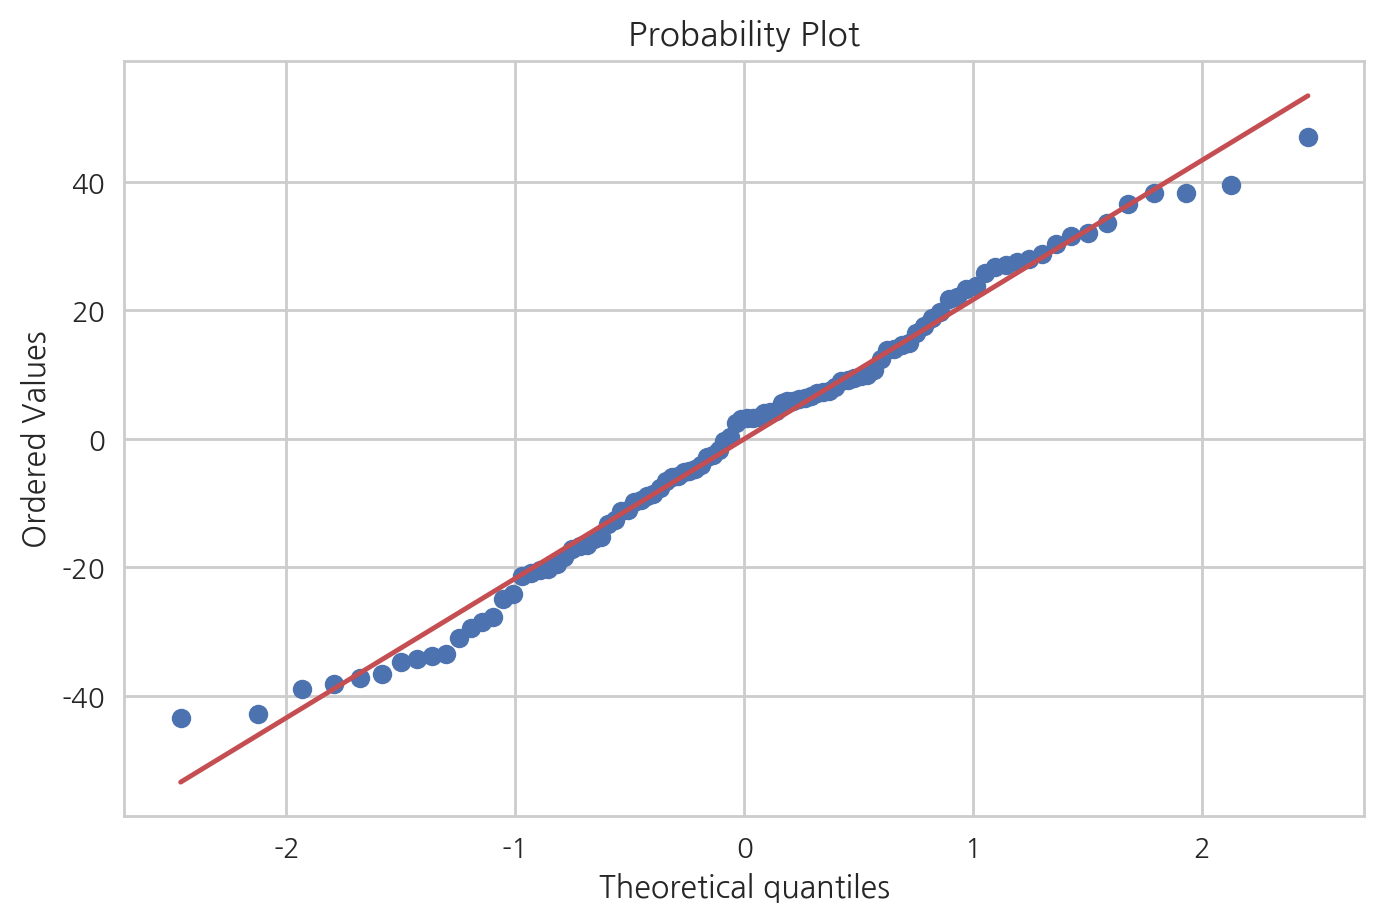

In [7]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

잔차의 정규성은 다음과 같이 정규성 검정을 통해 살펴볼 수도 있다.

In [8]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [9]:
test = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


다음은 $x$값이 달라짐에 따라 잔차의 분포가 어떻게 바뀌는 지를 살펴보기 위한 것이다. $x$값이 달라져도 분포의 형태가 크게 바뀌지 않음을 알 수 있다.

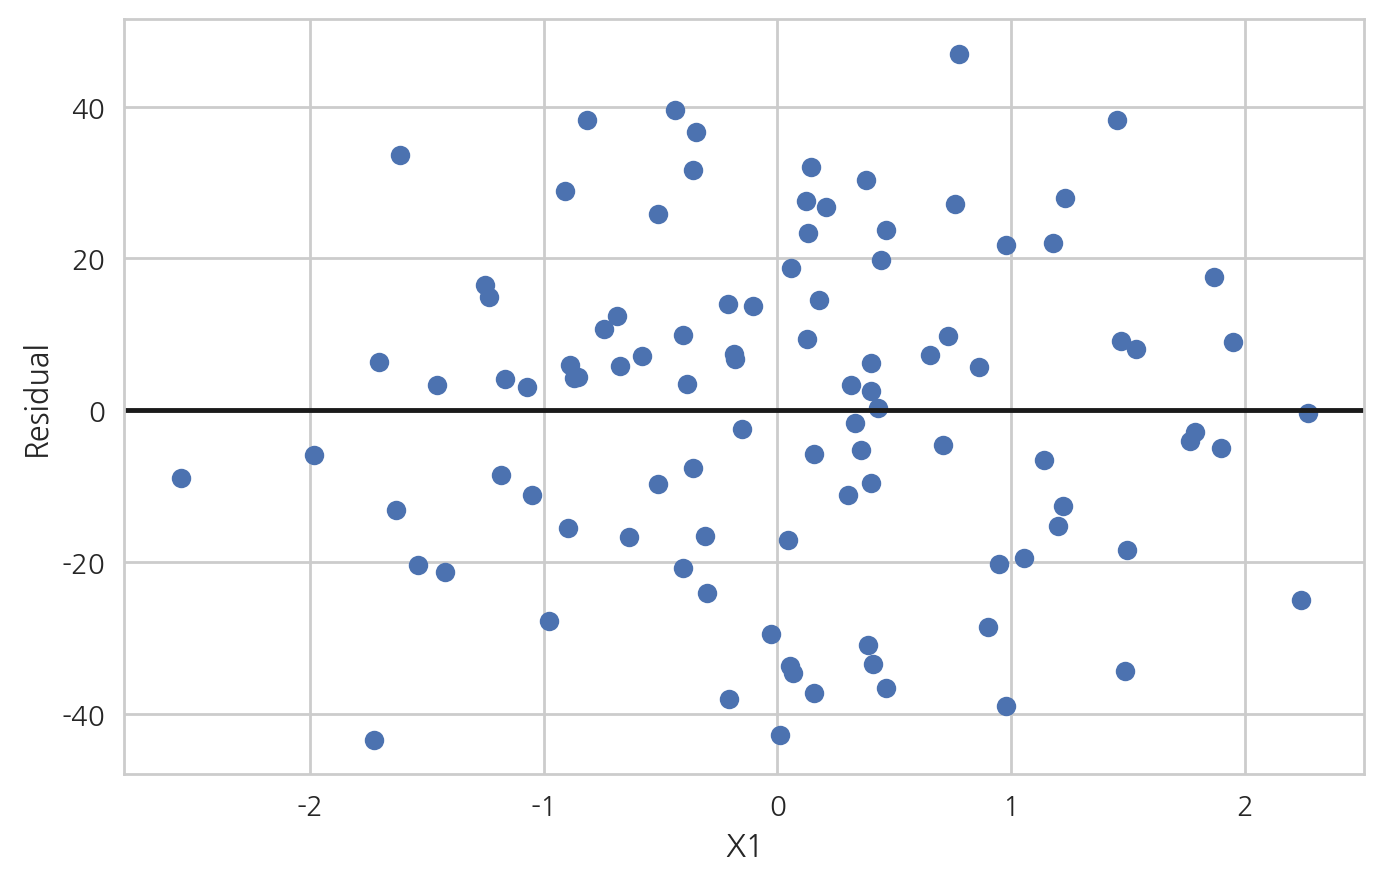

In [10]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

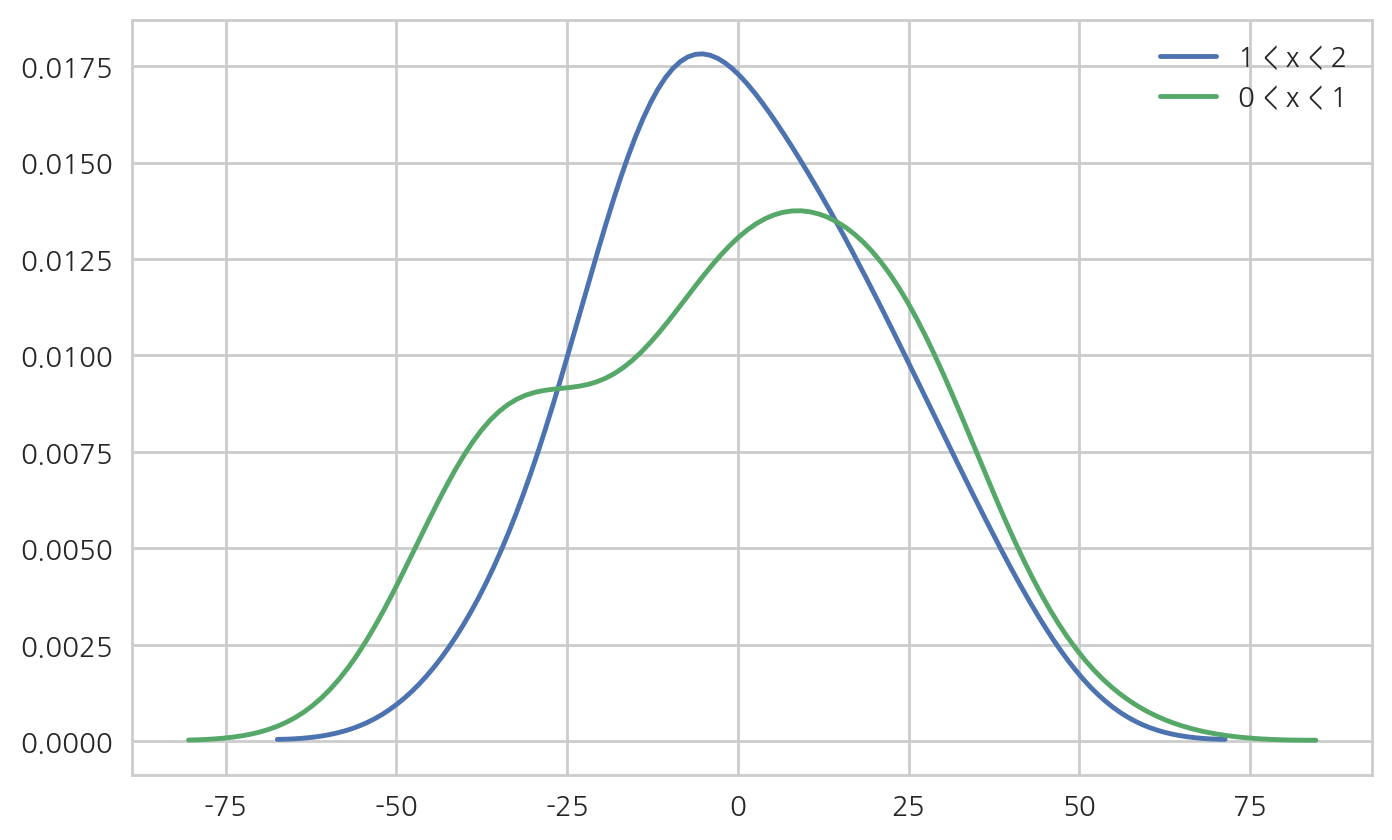

In [11]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

만약 데이터가 위와 같은 가정을 따르지 않는다면 어떻게 될까? 예를 들어 다음과 같은 데이터를 생각하자.

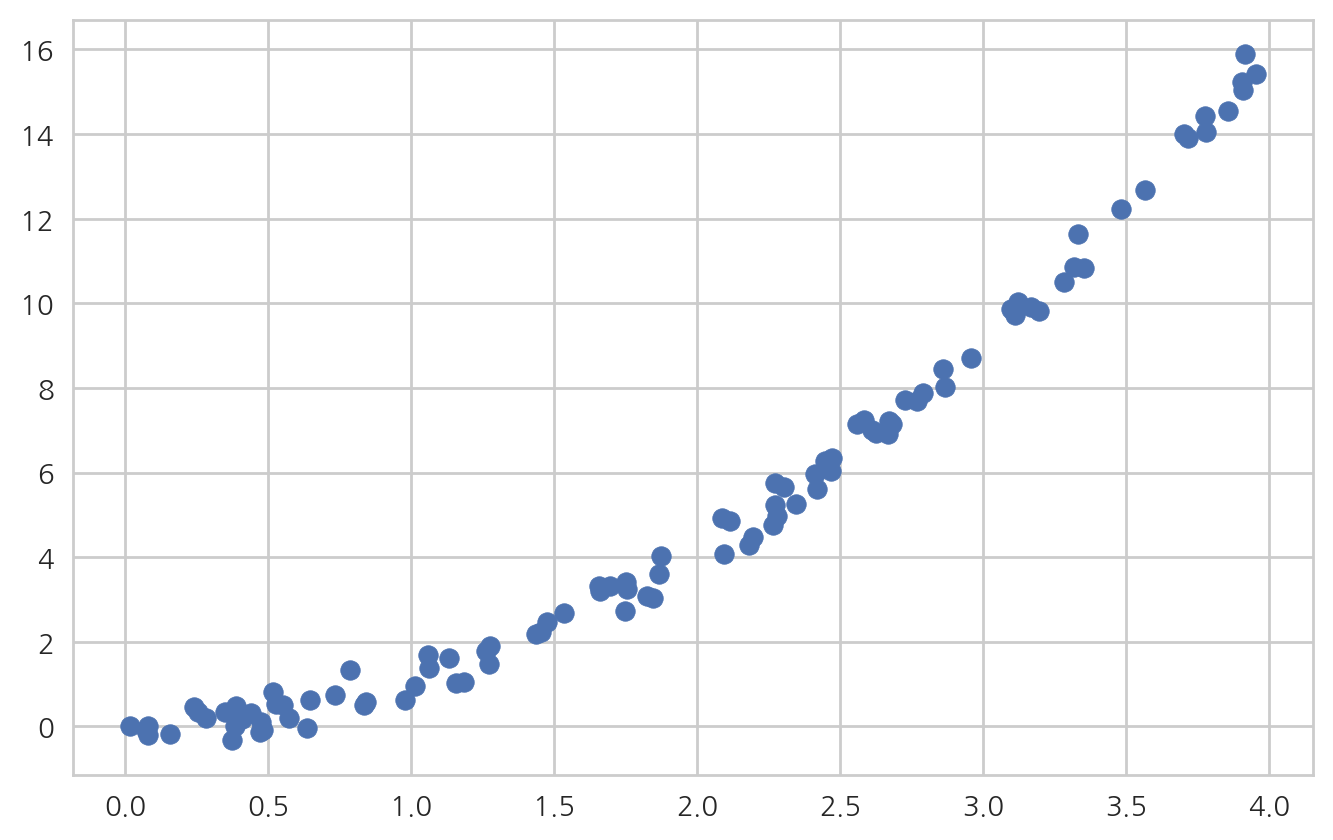

In [12]:
def make_regression2(n_sample = 100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y

x2, y2 = make_regression2()
plt.scatter(x2, y2)
plt.show()

In [13]:
dfX20 = pd.DataFrame(x2, columns=["X1"])
dfX2 = sm.add_constant(dfX20)
dfy2 = pd.DataFrame(y2, columns=["y"])

model2 = sm.OLS(dfy2, dfX2)
result2 = model2.fit()

QQ플롯과 정규성 검정에서 보듯이 잔차는 정규 분포를 따르지 않는다.

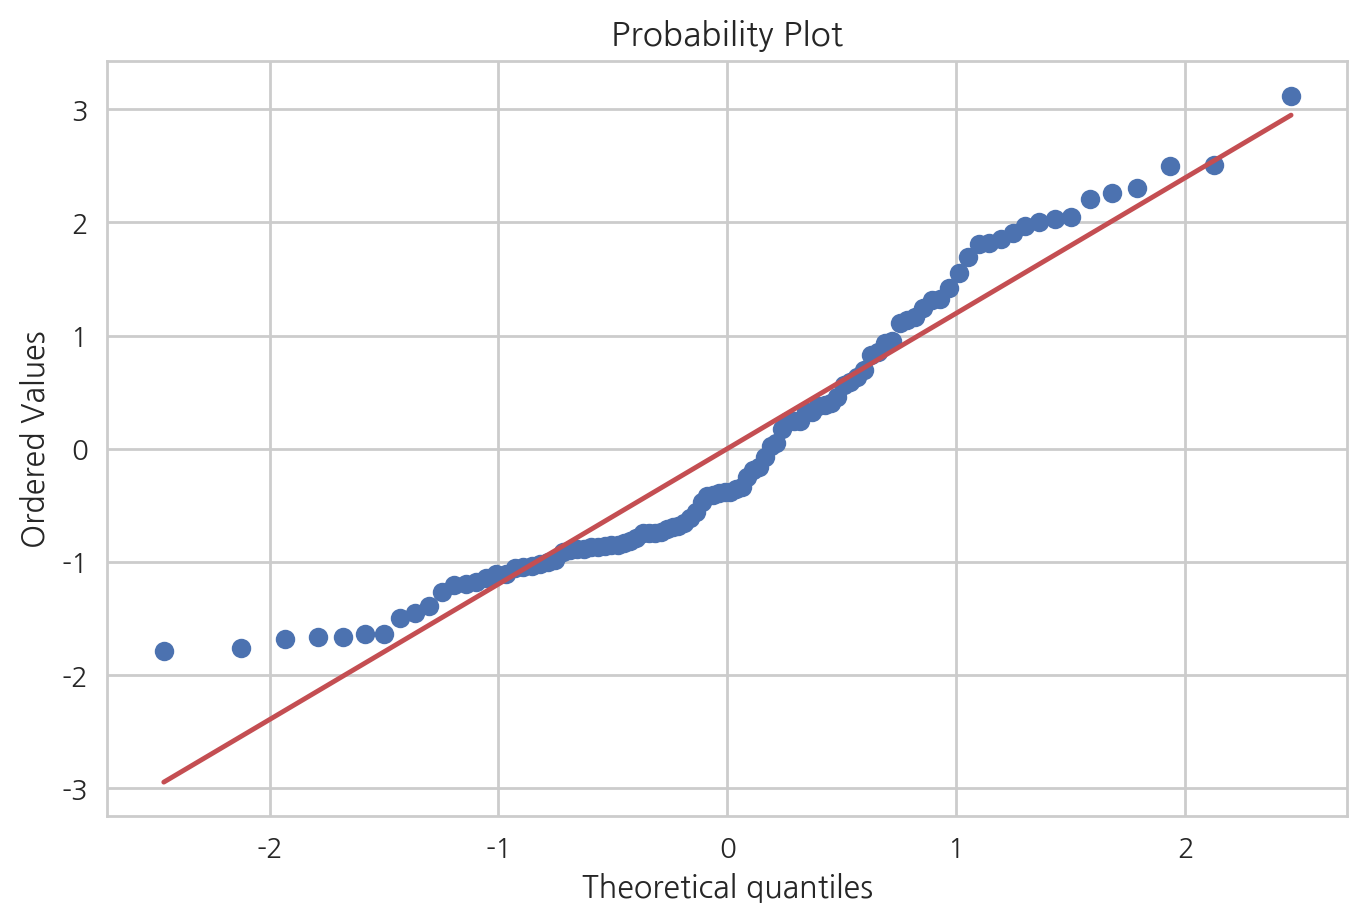

In [14]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [15]:
test = sms.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


이번에는 또다른 데이터를 살펴보자.

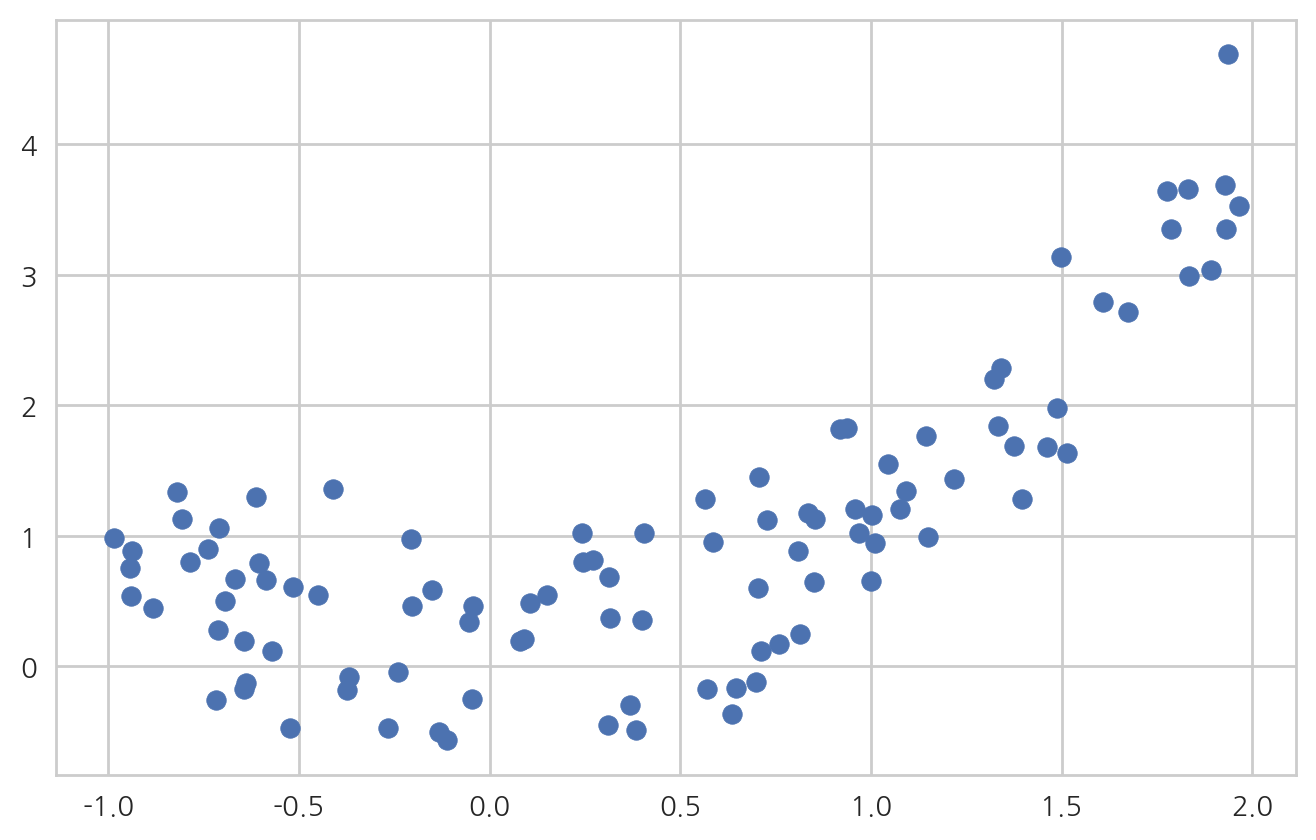

In [16]:
def make_regression3(n_sample = 100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y

x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show() ## 하기의 그림은 엡실론이 독립변수 x 에 영향을 받는다 그래서 쓰면 안됨 (x d와 엡실론은 독립이어야함 )

In [17]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

전체 잔차는 정규 분포를 따르지만 $x$값에 의존하고 있다는 것을 알 수 있다. 
* 엡실론은 x와 표준편차와 독립이어야 함 , 엡실론 끼리도 독립이어야한다 


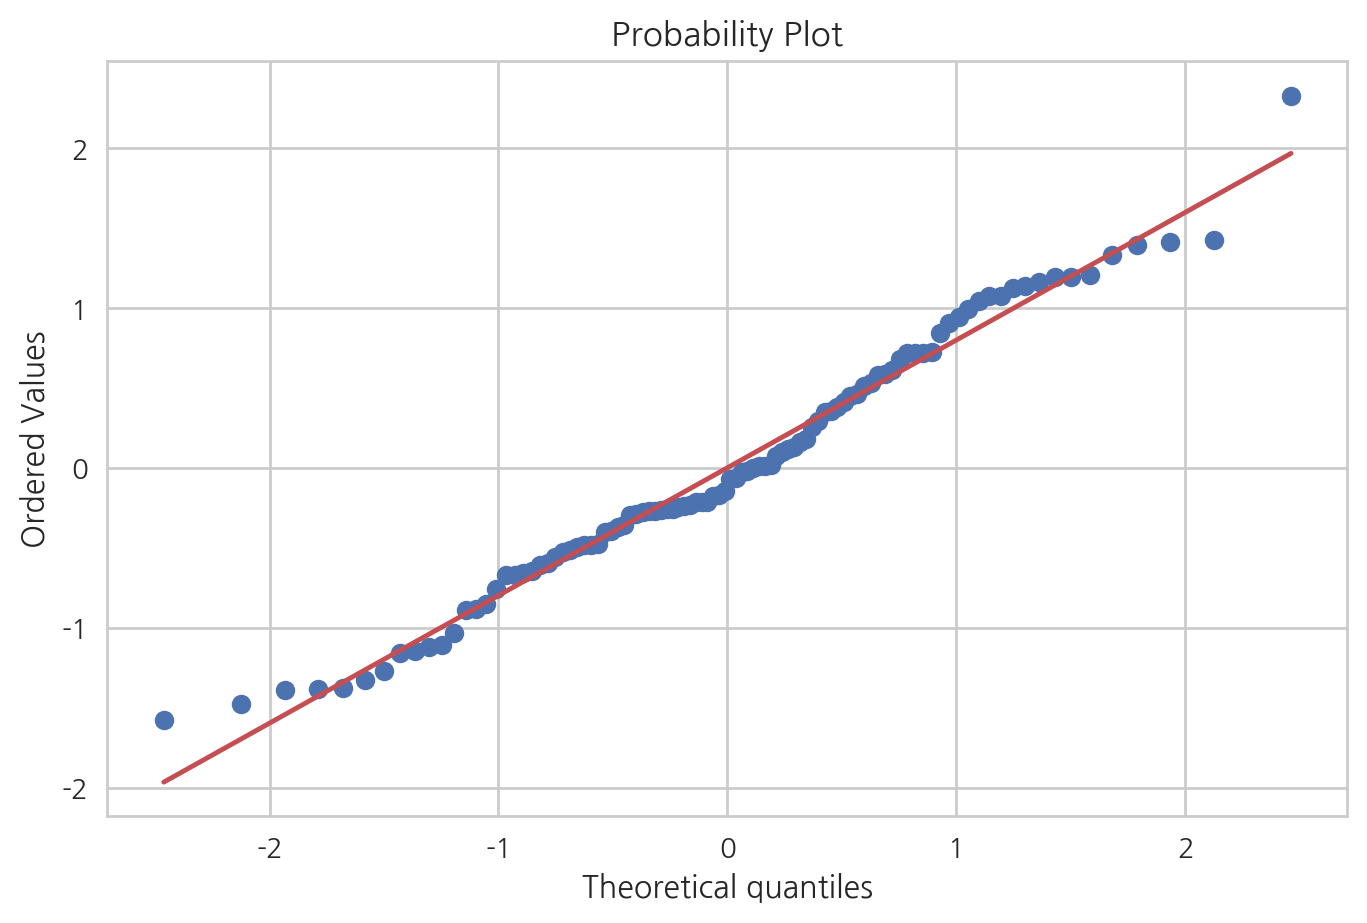

In [18]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show() ## 

In [19]:
test = sms.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  1.202
P-value     :  0.548


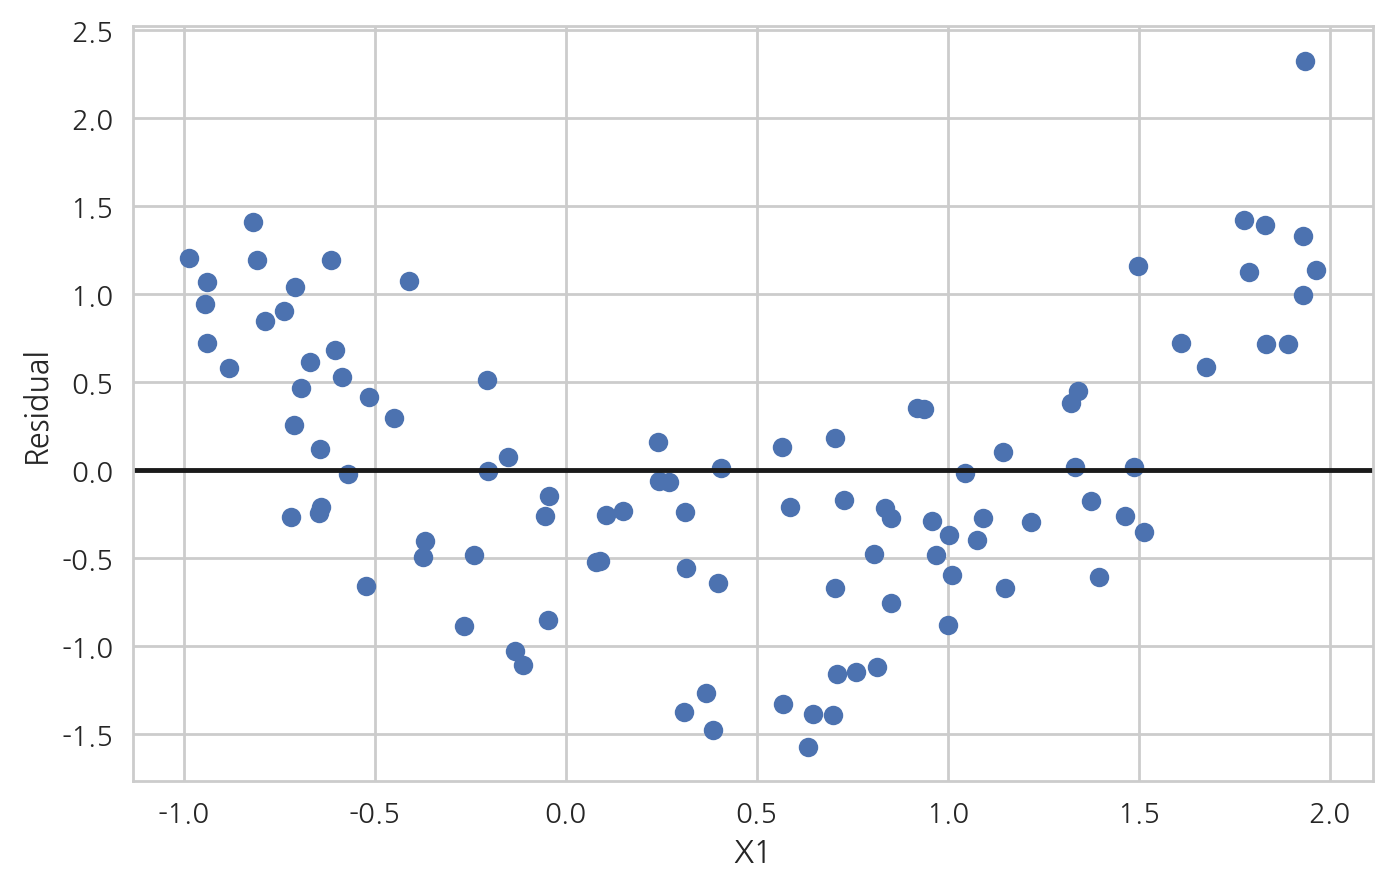

In [20]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

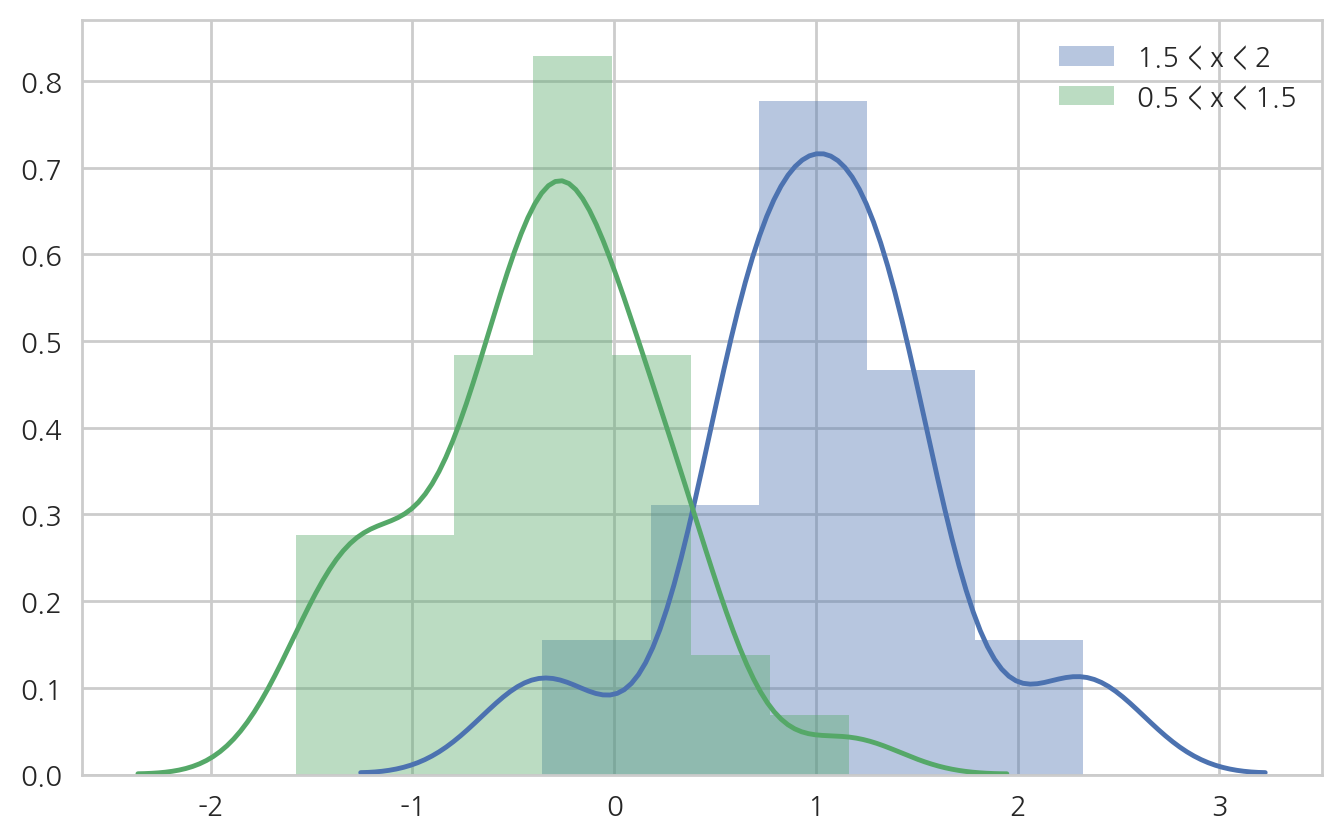

In [21]:
sns.distplot(result3.resid[((1.5 < x3) & (x3 < 2))], label="1.5 < x < 2")
sns.distplot(result3.resid[((0.5 < x3) & (x3 < 1.5))], label="0.5 < x < 1.5")
plt.legend()
plt.show()

## 회귀 계수의 표준 오차

가중치 $\hat{w}$ 도 정규 분포 확률 변수인 $y$의 선형 변환이므로 정규 분포를 따른다.

$$  
\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\
&=& w + (X^TX)^{-1} X^T \epsilon \\
\end{eqnarray}
$$

따라서 가중치의 기댓값은 다음과 같다.

$$  
\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w + (X^TX)^{-1} X^T \epsilon ] \\
&=&  w + (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\
&=& w
\end{eqnarray}
$$


가중치의 (공)분산을 계산하면 다음과 같다.


$$
\begin{eqnarray}
\text{Cov}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}
$$


$\sigma^2$의 값은 알지 못하므로 다음과 같이 추정한다.

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$
##### N-1/N 일경우 분산이 작아지면서 overfitting됨 그것을 막기위해 N 대신 N-k로 설정하여 분산이 작아지는것을 좀더 막음
여기에서 $N$은 표본 데이터의 수, $K$는 독립 변수의 수이다.

따라서 $\hat{w}$의 (공)분산의 추정값은 다음과 같다.

$$ \text{Est.Cov}[\hat{w}]  = s^2(X^TX)^{-1}$$

이 공분산 행렬에서 우리가 관심을 가지는 값은 $w_i$의 분산을 뜻하는 대각 성분이다.

$$\text{Est.Var}[\hat{w}_i]  = \left( \text{Est.Cov}[\hat{w}] \right)_{ii} $$


이 값에서 구한 표준 편차를 **회귀 계수의 표준 오차(Standard Error of Regression Coefficient)**라고 한다.

 $$ {se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} $$

## 단일 계수 t-검정 (Single Coefficient t-test)

$\hat{w}$을 위에서 구한 표준 오차로 나눈 값은 자유도가 $N-K$인 스튜던트 t 분포를 따른다.

$$  \dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} $$

이를 검정 통계량(test statistics)로 사용하면 특정 회귀 계수 $w_i$가 0 인지 아닌지에 대해 조사할 수 있다.

$$ H_0 : \;\; w_i = 0 $$

만약 유의확률이 0에 가깝게 나온다면 위의 귀무가설은 기각이므로 $w_i$ 값이 0일 가능성은 적다. 하지만 유의확률이 유의수준을 넘는 큰 값이 나온다면 반대로 $w_i$ 값이 0일 가능성이 크다. 즉, 해당 독립변수는 종속변수와 아무런 상관성이 없을 가능성이 있다는 뜻이다.

StatsModels `summary` 메서드가 출력하는 회귀분석 보고서에서 `std err`로 표시된 열이 모형계수의 표준오차, `t`로 표시된 열이 단일 계수 t-검정의 검정 통계량, 그리고 `P>|t|`로 표시된 열이 유의확률을 뜻한다. 

아래의 보고서에서는 첫번째 모형계수는 실제 값이 0일 가능성 즉, 상수항을 가지지 않을 가능성이 높다고 할 수 있다.

In [22]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Mon, 26 Jun 2017   Prob (F-statistic):           2.21e-36
Time:                        19:03:14   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

## Loss-of-Fit 검정 (회귀 분석 F-검정)

개별 개수가 아닌 전체 회귀 계수가 모두 의미가 있는지 확인하려면 에 대해 다음과 같은 귀무 가설을 생각할 수 있다.

$$ H_0 : w_1  = w_2 = \cdots = w_K = 0 $$

이는 전체 독립 변수 중 어느 것도 의미를 가진 것이 없다는 뜻이다. 대부분의 경우, 이 귀무가설은 기각되는데 유의확률이 얼마나 작은가에 따라서 기각되는 정도가 달라진다. 즉, 유의확률이 작으면 작을 수록 더 강력하게 기각된 것이므로 더 의미가 있는 모형이 된다. 따라서 여러 모형의 유의확률을 비교하면 어느 모형이 더 성능이 좋은가를 비교할 수 있다. 이러한 귀무 가설을 검정하는 것을 Loss-of-Fit 검정 또는 회귀 분석 F-검정(regression F-test)이라고 한다.

위 보고서에서 `F-statistic`라고 표시된 `400.3`이라는 값이 회귀분석 F-검정의 검정통계량이고 `Prob (F-statistic)`로 표시된 `2.21e-36`라는 값이 유의확률이다.